In [1]:
import numpy as np
import copy
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, Sequential
from keras import regularizers
from keras import backend as K
import Data_prep as dp
from scipy.io import savemat, loadmat
from keras.losses import mse, binary_crossentropy
from keras.layers import Reshape, Lambda, Input, Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import Activation, ZeroPadding2D, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
K.set_image_data_format('channels_last')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def sampling(input_param):
    """
    sampling the latent space from a Gaussian distribution:

    # Input
        input_param: mean and log of variance of q(z|x)

    # Output
        z: sampled latent space vector
    """
    
    #mean and log(var):
    z_mean, z_log_var = input_param 
    
    #dimensions:
    dim_1 = K.shape(z_mean)[0]
    dim_2 = K.int_shape(z_mean)[1]
    
    #sampling:
    norm_sample = K.random_normal(shape=(dim_1, dim_2))
    return z_mean + K.exp(0.5 * z_log_var) * norm_sample

In [39]:
#encoder network:

#regularization coefficient:
l_encode=0.001

#act. func. (hidden layers)
act='tanh'

#act. func. (output layers)
act_out='linear'

#input:
bathy_input = Input(shape=(41,501, 1), name = 'bathymetry')

#CNN/pooling layer 1&2:
x = Conv2D(2, (3, 3), strides=1, padding='same',kernel_regularizer = regularizers.l2(l_encode))(bathy_input)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = Conv2D(2, (3, 3), strides=1, padding='same',kernel_regularizer = regularizers.l2(l_encode))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#CNN/pooling layer 3&4:
x = Conv2D(4, (3, 3), strides=1, padding='same',kernel_regularizer = regularizers.l2(l_encode))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = Conv2D(4, (3, 3), strides=1, padding='same',kernel_regularizer = regularizers.l2(l_encode))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#flattening:
shape = K.int_shape(x)
x = Flatten()(x)

#fully connected layer 1:
x = Dense(1000,kernel_regularizer = regularizers.l2(l_encode))(x)
x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#fully connected layer 2:
x = Dense(200,kernel_regularizer = regularizers.l2(l_encode))(x)
x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#output:
z_mean = Dense(50,activation=act_out,name='z_mean')(x)
z_log_var = Dense(50,activation=act_out,name='z_log_var')(x)
z = Lambda(sampling, output_shape=(50,), name='latent_encode')([z_mean, z_log_var])

#set encoder model:
encoder = Model(bathy_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bathymetry (InputLayer)         (None, 41, 501, 1)   0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 41, 501, 2)   20          bathymetry[0][0]                 
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 41, 501, 2)   8           conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 41, 501, 2)   0           batch_normalization_59[0][0]     
____________________________________________________________________________________________

In [40]:
#decoder network:

#regularization coefficient
l_decode=0.0

#input/BC:
BC_input = Input(shape=(2, ), name = 'BC') #BC
latent_input = Input(shape=(50,), name='latent_decode') #input
x = keras.layers.concatenate([latent_input, BC_input])

#fully connected layer 1:
x = Dense(200, kernel_regularizer = regularizers.l2(l_decode))(x)
x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#fully connected layer 2:
x = Dense(1000, kernel_regularizer = regularizers.l2(l_decode))(x)
x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#FC/CNN connection & reshaping:
x = Dense((shape[1]-1)*(shape[2]-1)*shape[3], kernel_regularizer = regularizers.l2(l_decode))(x)
x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)
x = Reshape((shape[1]-1, shape[2]-1, shape[3]))(x)

#CNN/upsampling layer 1:
x = Conv2DTranspose(4, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = Conv2DTranspose(4, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#CNN/upsampling layer 2:
x = Conv2DTranspose(2, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = Conv2DTranspose(2, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#output:
outputs = Conv2DTranspose(1, (3, 3), activation=act_out, padding='same', name='velocity')(x)

#set decoder model:
decoder = Model([latent_input,BC_input], outputs, name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_decode (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 52)           0           latent_decode[0][0]              
                                                                 BC[0][0]                         
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 200)          10600       concatenate_5[0][0]        

In [41]:
#set VAE model
vae_outputs = decoder([encoder(bathy_input)[2],BC_input])
vae = Model([bathy_input,BC_input], vae_outputs, name='vae')

In [42]:
#VAE loss function (can use loss='mse'+'KL divergence'):

def vae_loss(y_true, y_pred):
    #KL coefficient:
    l_kl=0.001 
    
    #mse loss:
    mse_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    
    #KL loss:
    kl_loss = - 0.5 * K.mean(1.0 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    #total loss
    vae_loss = mse_loss +l_kl*kl_loss
    return vae_loss

In [43]:
#compile VAE:

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001, amsgrad=False)

vae.compile(optimizer=opt, loss=vae_loss)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bathymetry (InputLayer)         (None, 41, 501, 1)   0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 50), (None,  5770430     bathymetry[0][0]                 
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
decoder (Model)                 (None, 40, 500, 1)   5241875     encoder[1][2]                    
                                                                 BC[0][0]                       

In [9]:
#load/read train and validation data

data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6.mat')

vel0 = data['velocity_prof'] #velocities
z_f0 = data['z_f'] #free surface elevation
Q_b0 = data['Q_b'] #influx
Z0 = data['Z'] #bathymetry

#check data shape:
print(z_f0.shape)
print(Z0.shape)

(1, 4500)
(20541, 4500)


In [10]:
#load/read test data

data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6_test.mat')

vel1 = data['velocity_prof'] #velocities
z_f1 = data['z_f'] #free surface elevation
Q_b1 = data['Q_b'] #influx
Z1 = data['Z'] #bathymetry

#check data shape:
print(z_f1.shape)
print(Z1.shape)

(1, 450)
(20541, 450)


In [11]:
#join train/validation and test set

vel = np.concatenate((vel0,vel1),axis=1)
z_f = np.concatenate((z_f0,z_f1),axis=1)
Q_b = np.concatenate((Q_b0,Q_b1),axis=1)
Z = np.concatenate((Z0,Z1),axis=1)
vx, vy, _ = dp.xy_vel_sep(vel) #v_x/v_y separation

#check data shape:
print(vel.shape)
print(z_f.shape)
print(vx.shape)
print(Z.shape)

(41082, 4950)
(1, 4950)
(20541, 4950)
(20541, 4950)


In [12]:
#put bathymetry in right shape:

Z_dummy = Z.reshape(41,501,-1) 
Z_new = np.zeros((Z_dummy.shape[2],Z_dummy.shape[0],Z_dummy.shape[1])) 
for i in range(Z_dummy.shape[2]):
    Z_new[i,:,:] = Z_dummy[:,:,i]     
del Z_dummy

#check Z_new shape:
print(Z_new.shape)

(4950, 41, 501)


In [13]:
#put v_x in right shape:

vx_dummy = vx.reshape(41,501,-1)
vx_new = np.zeros((vx_dummy.shape[2],vx_dummy.shape[0],vx_dummy.shape[1]))
for i in range(vx_dummy.shape[2]):
    vx_new[i,:,:] = vx_dummy[:,:,i]
del vx_dummy

#check vx_new shape:
print(vx_new.shape)

(4950, 41, 501)


In [14]:
#put v_y in right shape (if necessary): 

vy_dummy = vy.reshape(41,501,-1)
vy_new = np.zeros((vy_dummy.shape[2],vy_dummy.shape[0],vy_dummy.shape[1]))
for i in range(vy_dummy.shape[2]):
    vy_new[i,:,:] = vy_dummy[:,:,i]
del vy_dummy

#check vy_new shape:
print(vy_new.shape)

(4950, 41, 501)


In [15]:
#add channel dimension:

x_train = Z_new.reshape(-1,41,501,1) #input (Z)
y_train = vx_new.reshape(-1,41,501,1) #output (vx; can be replaced with vy or both vx/vy)

#check shapes:
print(x_train.shape)
print(y_train.shape)

(4950, 41, 501, 1)
(4950, 41, 501, 1)


In [16]:
#find normalizing parameters:

N=4500 # number of data to be used (train+validation)

x_min = np.mean(x_train[:N,:,:,:], axis=0)
y_min = np.mean(y_train[:N,:,:,:], axis=0)
x_range = np.std(x_train[:N,:,:,:], axis=0)
x_range[x_range==0]=1
y_range = np.std(y_train[:N,:,:,:], axis=0)
y_range[y_range==0]=1

#check shapes:
print(x_min.shape)
print(y_min.shape)
print(x_range.shape)
print(y_range.shape)

(41, 501, 1)
(41, 501, 1)
(41, 501, 1)
(41, 501, 1)


In [17]:
#normalize input/outputs:

x_train_norm = (x_train-x_min)/x_range 
y_train_norm = (y_train-y_min)/y_range 

#check shapes:
print(x_train_norm.shape)
print(y_train_norm.shape)

#check min/max:
print(np.min(x_train_norm))
print(np.min(y_train_norm))
print(np.max(x_train_norm))
print(np.max(y_train_norm))

(4950, 41, 501, 1)
(4950, 41, 501, 1)
-4.711301465906763
-10.378835518374794
3.3733705633020246
10.965771092609335


In [18]:
#normalize BC (ensure it's between 0 and 1):

BC = np.zeros((2, z_f.shape[1]))
BC[0,:] = z_f/120
BC[1,:] = Q_b/30000

#check shapes and maxes:
print(BC.shape)
print(max(BC[0,:]))
print(max(BC[1,:]))

(2, 4950)
0.9531882083041187
0.9988410701086574


In [19]:
# data preparation:

#generate a seed number for reproducibility:
seed_num=np.random.randint(0,1e5) 
#seed_num=0 #use for reproducing a previously known seed #
print(seed_num)

#generate seed:
np.random.seed(seed_num)

M=0 #where the first index of data is
P=450 #size of test set
H=10 #number of BCs for each profile

#shuffle based on the seed:
indx=np.array(np.arange(0+M,x_train_norm[0:,:,:,:].shape[0]-P,H),dtype=int) #original indices (ascending) 
indx_new=copy.deepcopy(indx) #new (to be shuffled) indices
np.random.shuffle(indx_new) #shuffled idices

#create shuffled input/outputs:
x_train_norm_shfl=copy.deepcopy(x_train_norm[0:,:,:,:])
y_train_norm_shfl=copy.deepcopy(y_train_norm[0:,:,:,:])
BC_shfl=copy.deepcopy(BC[:,0:])
for i in range(indx_new.shape[0]):
    x_train_norm_shfl[i*H+M:i*H+H+M,:,:,:]=x_train_norm[indx_new[i]:indx_new[i]+H,:,:,:]
    y_train_norm_shfl[i*H+M:i*H+H+M,:,:,:]=y_train_norm[indx_new[i]:indx_new[i]+H,:,:,:]
    BC_shfl[:,i*H+M:i*H+H+M]=BC[:,indx_new[i]:indx_new[i]+H]

66396


In [54]:
#training:

val_split=0.1 #validation split (fraction of train/validation set to be used for validation)

#vae.load_weights('vae_f_Sav_BC_func_m4500_22_44_B_1000_200_50_l0_001_1_0tantanlr0_001B.h5') #to load saved weights, if necessary
vae.fit(x={'bathymetry':x_train_norm_shfl[:-P,:,:,:], 'BC':BC_shfl[:,:-P].T},y=y_train_norm_shfl[:-P,:40,:500,:],
       epochs=100,batch_size=32,shuffle=False,validation_split=val_split)
vae.save_weights('vae_f_Sav_BC_func_m4500_22_44_B_1000_200_50_l0_001_1_0tantanlr0_001B.h5') #to save optimized weights

Train on 4050 samples, validate on 450 samples
Epoch 1/10
4050/4050 [==============================] - 62s 15ms/step - loss: 0.1039 - val_loss: 0.1973
Epoch 2/10
4050/4050 [==============================] - 62s 15ms/step - loss: 0.1013 - val_loss: 0.2019
Epoch 3/10
4050/4050 [==============================] - 63s 16ms/step - loss: 0.0994 - val_loss: 0.1889
Epoch 4/10
4050/4050 [==============================] - 62s 15ms/step - loss: 0.0989 - val_loss: 0.1966
Epoch 5/10
4050/4050 [==============================] - 64s 16ms/step - loss: 0.0987 - val_loss: 0.2005
Epoch 6/10
4050/4050 [==============================] - 60s 15ms/step - loss: 0.0984 - val_loss: 0.1971
Epoch 7/10
4050/4050 [==============================] - 61s 15ms/step - loss: 0.0966 - val_loss: 0.1901
Epoch 8/10
4050/4050 [==============================] - 59s 15ms/step - loss: 0.0936 - val_loss: 0.1914
Epoch 9/10
4050/4050 [==============================] - 59s 15ms/step - loss: 0.0923 - val_loss: 0.1910
Epoch 10/10
4050/

In [55]:
#calculate VAE predictions (normalized):

z_mean_pred, z_log_pred, z_pred= encoder.predict(x_train_norm_shfl) #encoder output
y_decoded_pred = decoder.predict([z_mean_pred,BC_shfl.T]) #decoder output

#check shape:
print(y_decoded_pred.shape)

(4950, 40, 500, 1)


In [56]:
#calculate VAE predictions:

y_pred=y_decoded_pred*y_range[:40,:500,:]+y_min[:40,:500,:] #predicted output

#check shape:
print(y_pred.shape)

(4950, 40, 500, 1)


In [57]:
#rmse of train/test/validation:

y_true=y_train_norm_shfl[:,:40,:500]*y_range[:40,:500,:]+y_min[:40,:500,:]
print('train err [ft/s]:',np.sqrt(np.mean((y_pred[:int(N-val_split*N),:,:]-y_true[:int(N-val_split*N),:40,:500])**2)))
print('test err [ft/s]:',np.sqrt(np.mean((y_pred[int(N-val_split*N):N,:,:]-y_true[int(N-val_split*N):N,:40,:500])**2)))
print('validation err [ft/s]:',np.sqrt(np.mean((y_pred[N:,:,:]-y_true[N:,:40,:500])**2)))

train err [ft/s]: 0.22038692514801408
test err [ft/s]: 0.23523404539795145
validation err [ft/s]: 0.24829939801042725


In [58]:
#prepare the data for plotting

x_plt=np.zeros((N+P,41, 501))
x_plt[:,:40,:500]=y_pred.squeeze()
x_plt[:, 40,:]=x_plt[:, 39,:]
x_plt[:, :,500]=x_plt[:, :,499]
y_plt=np.zeros((N+P,41, 501))
y_plt[:,:40,:500]=y_true.squeeze()
y_plt[:, 40,:]=y_plt[:, 39,:]
y_plt[:, :,500]=y_plt[:, :,499]

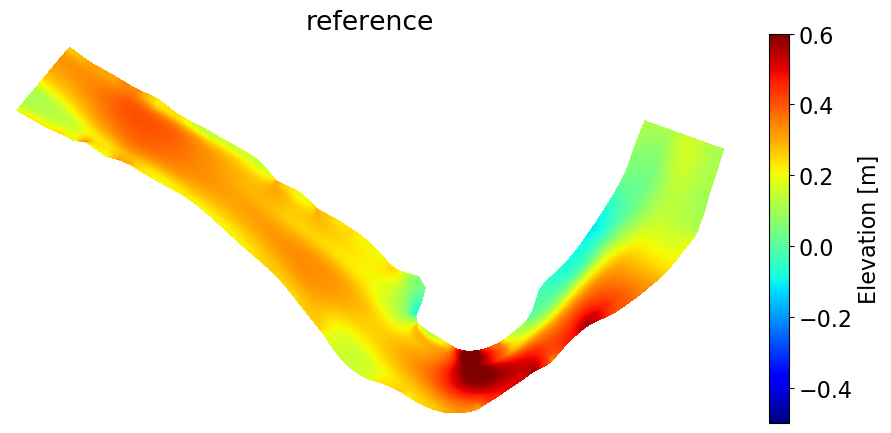

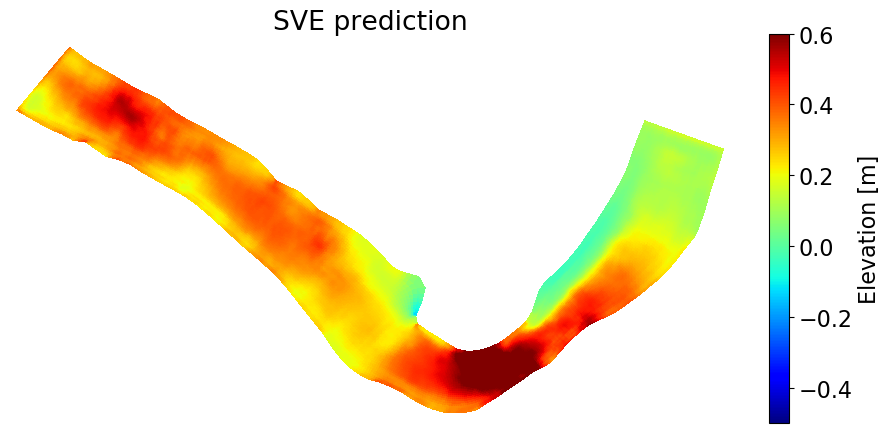

In [59]:
#plot some results:

#index (k<int(N-val_split*N) is a train data, int(N-val_split*N)<k<N is a test data, k>N is a validation data)
k=4700

dp.plt_im_tri(depth=y_plt[k, :,:].ravel(), fig_title= 'reference', fig_name='ref_global.png',vmin_=-0.5, vmax_=0.6)
dp.plt_im_tri(depth=(x_plt[k, :,:]).ravel(), fig_title= 'SVE prediction', fig_name='SVE_global.png',vmin_=-0.5, vmax_=0.6)